# CIFAR-10

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset

from torchvision import models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.neighbors import KernelDensity

from tqdm import tqdm

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from PIL import Image

from joblib import Parallel, delayed

from utlis import renormalize_image, vectorize_tensor, reconstruct_tensor
import ld

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

## Setup

### General

In [2]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    cp.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

load = True

set_random_seed(22)
k = 3
bandwidth = 0.05
bandwidth_AE = 0.05
eps = np.asarray(1.0e-5)
plot_num = 20
paper_plot_num = 1

### Dataset

In [3]:
class NumpyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy.array): Array of shape (N, H, W, C).
            labels (numpy.array): Labels array of shape (N,).
            transform (callable, optional): Transformations to apply to each sample.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        # Convert (H, W, C) -> (C, H, W) for PyTorch
        img = torch.tensor(img).permute(2, 0, 1).float() / 255.0

        # Apply transformation if provided
        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
D = 32*32*3
S = (2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2)
train_size_per_class = 5000
new_sample_size_per_class = 1000
num_class = 10

# Print dataset statistics
print(f"Train size: {train_size_per_class * num_class}")
print(f"New sample size: {new_sample_size_per_class * num_class}")
print(f"Number of classes: {num_class}")
print(f"Number of features: {D}")

Train size: 50000
New sample size: 10000
Number of classes: 10
Number of features: 3072


In [5]:
train_dataset = datasets.CIFAR10(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),]))

save_dir = './data/CIFAR10_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    # Save images by class
    for class_label in range(num_class):
        class_dir = os.path.join(save_dir, str(class_label))
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        basis = np.where(np.array(train_dataset.targets) == class_label)[0]
        for i, idx in enumerate(basis):
            img, _ = train_dataset[idx]
            img = transforms.ToPILImage()(img)
            img.save(os.path.join(class_dir, f'{i}.png'))

Files already downloaded and verified
Files already downloaded and verified


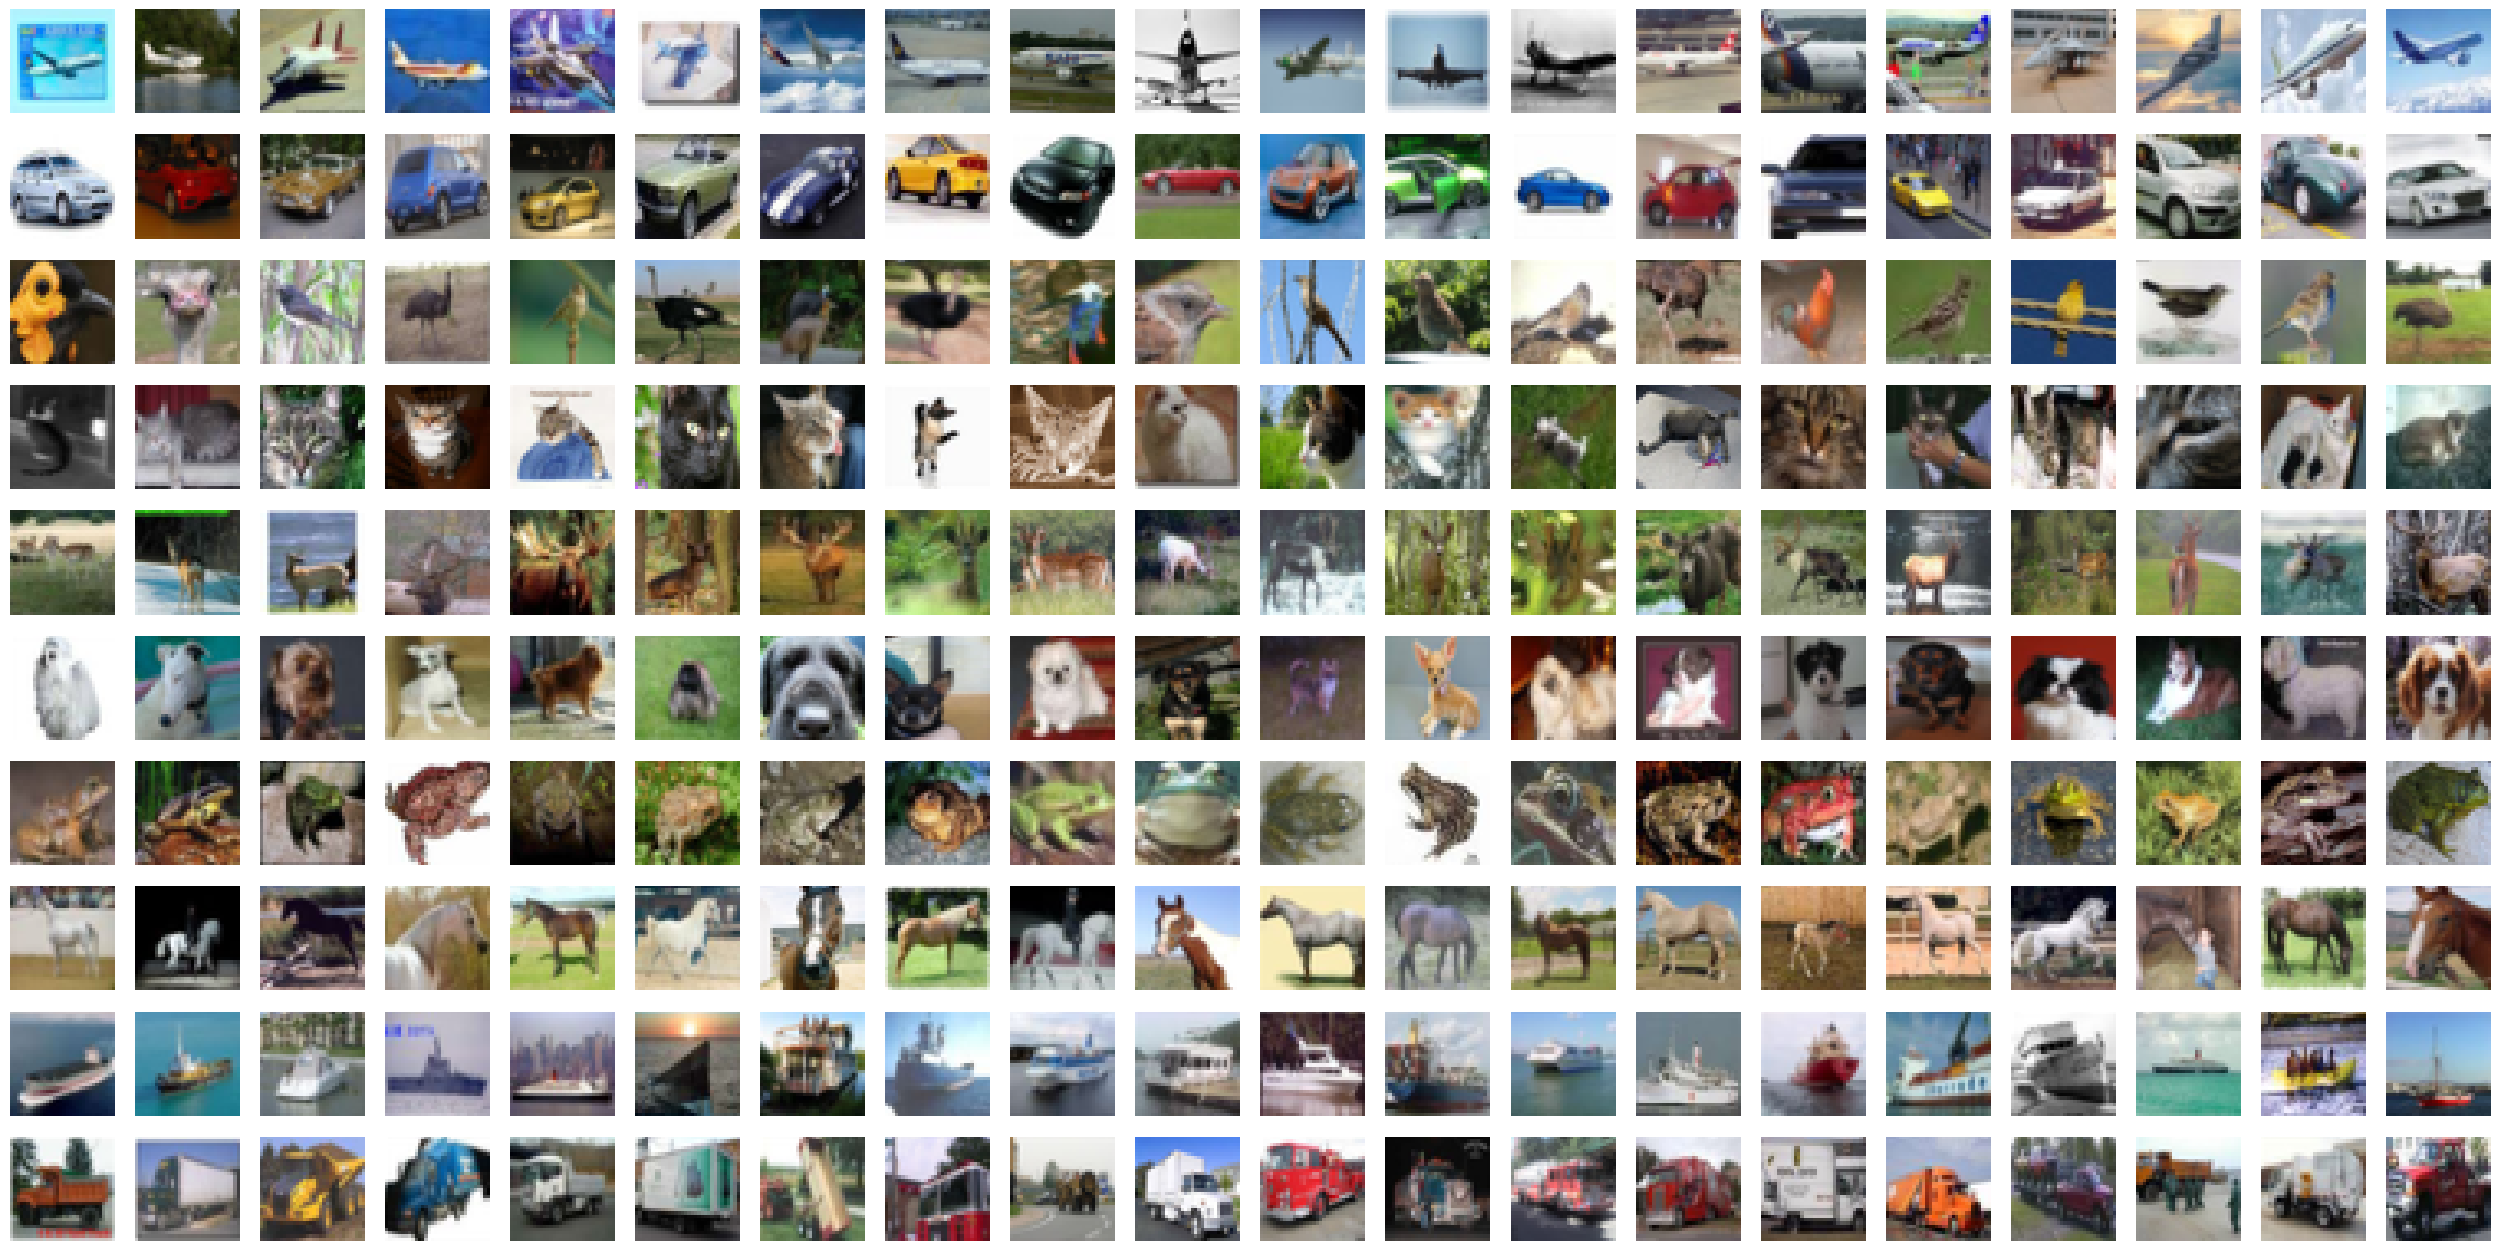

In [6]:
# Function to load images from a directory
def load_images_from_folder(folder, max_images=20):
    images = []
    for filename in os.listdir(folder)[:max_images]:
        file_path = os.path.join(folder, filename)
        with Image.open(file_path) as img:  # Ensure the file handle is closed after opening
            images.append(img.copy())  # Make a copy of the image to keep it in memory
    return images

P_class = []

for class_ in range(num_class):
    class_folder = os.path.join(save_dir, str(class_))
    images = load_images_from_folder(class_folder, max_images=train_size_per_class)

    P = []
    for img in images:
        img = img.resize((32, 32))
        array_obj = np.asarray(img).reshape(S)
        P.append(array_obj)

    P_class.append(np.array(P))

# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for class_ in range(num_class):
    for i in range(plot_num):
        plt.subplot(num_class, plot_num, class_ * plot_num + i + 1)
        plt.imshow(P_class[class_][i].reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

## Pseudo-Non-Linear Data Augmentation

### Legendre Decomposition (Many-Body Approximation)

In [7]:
B_LD = ld.default_B(S, 5, cp.get_array_module(P[0]))
print(f"Dimension of Base Sub-Manifold: {B_LD.shape[0]}")

# Store all intermediate results to disk
if load:
    # Load all intermediate results from disk
    results = np.load('results_LD.npz')
    scaleX_class = results['scaleX_class']
    Q_class = results['Q_class']
    theta_class = results['theta_class']
    X_recons_class = results['X_recons_class']
else:
    import tempfile
    temp_dir = tempfile.mkdtemp(dir='/data/pbb/tmp')

    def LD_helper(i, class_):
        _, _, scaleX, Q, theta = ld.LD(P_class[class_][i], B=B_LD, verbose=False, n_iter=1000, lr=1e-1)
        return (scaleX, Q, theta)


    results = Parallel(n_jobs=30, temp_folder=temp_dir)(delayed(LD_helper)(i, class_) for i in range(train_size_per_class) for class_ in range(num_class))

    scaleX_class = []
    Q_class = []
    theta_class = []
    X_recons_class = []

    for class_ in range(num_class):
        scaleX_list = []
        Q_list = []
        theta_list = []
        X_recons_list = []
        for i in range(train_size_per_class):
            result = results[i*num_class + class_]

            scaleX_list.append(result[0])
            Q_list.append(result[1])
            theta_list.append(result[2])
            X_recons = (result[1] * result[0]).astype(np.int32)
            X_recons_list.append(X_recons)

        scaleX_class.append(np.array(scaleX_list))
        Q_class.append(np.array(Q_list))
        theta_class.append(np.array(theta_list))
        X_recons_class.append(np.array(X_recons_list))

    np.savez('results_LD.npz', scaleX_class=scaleX_class, Q_class=Q_class, theta_class=theta_class, X_recons_class=X_recons_class)

Dimension of Base Sub-Manifold: 1410


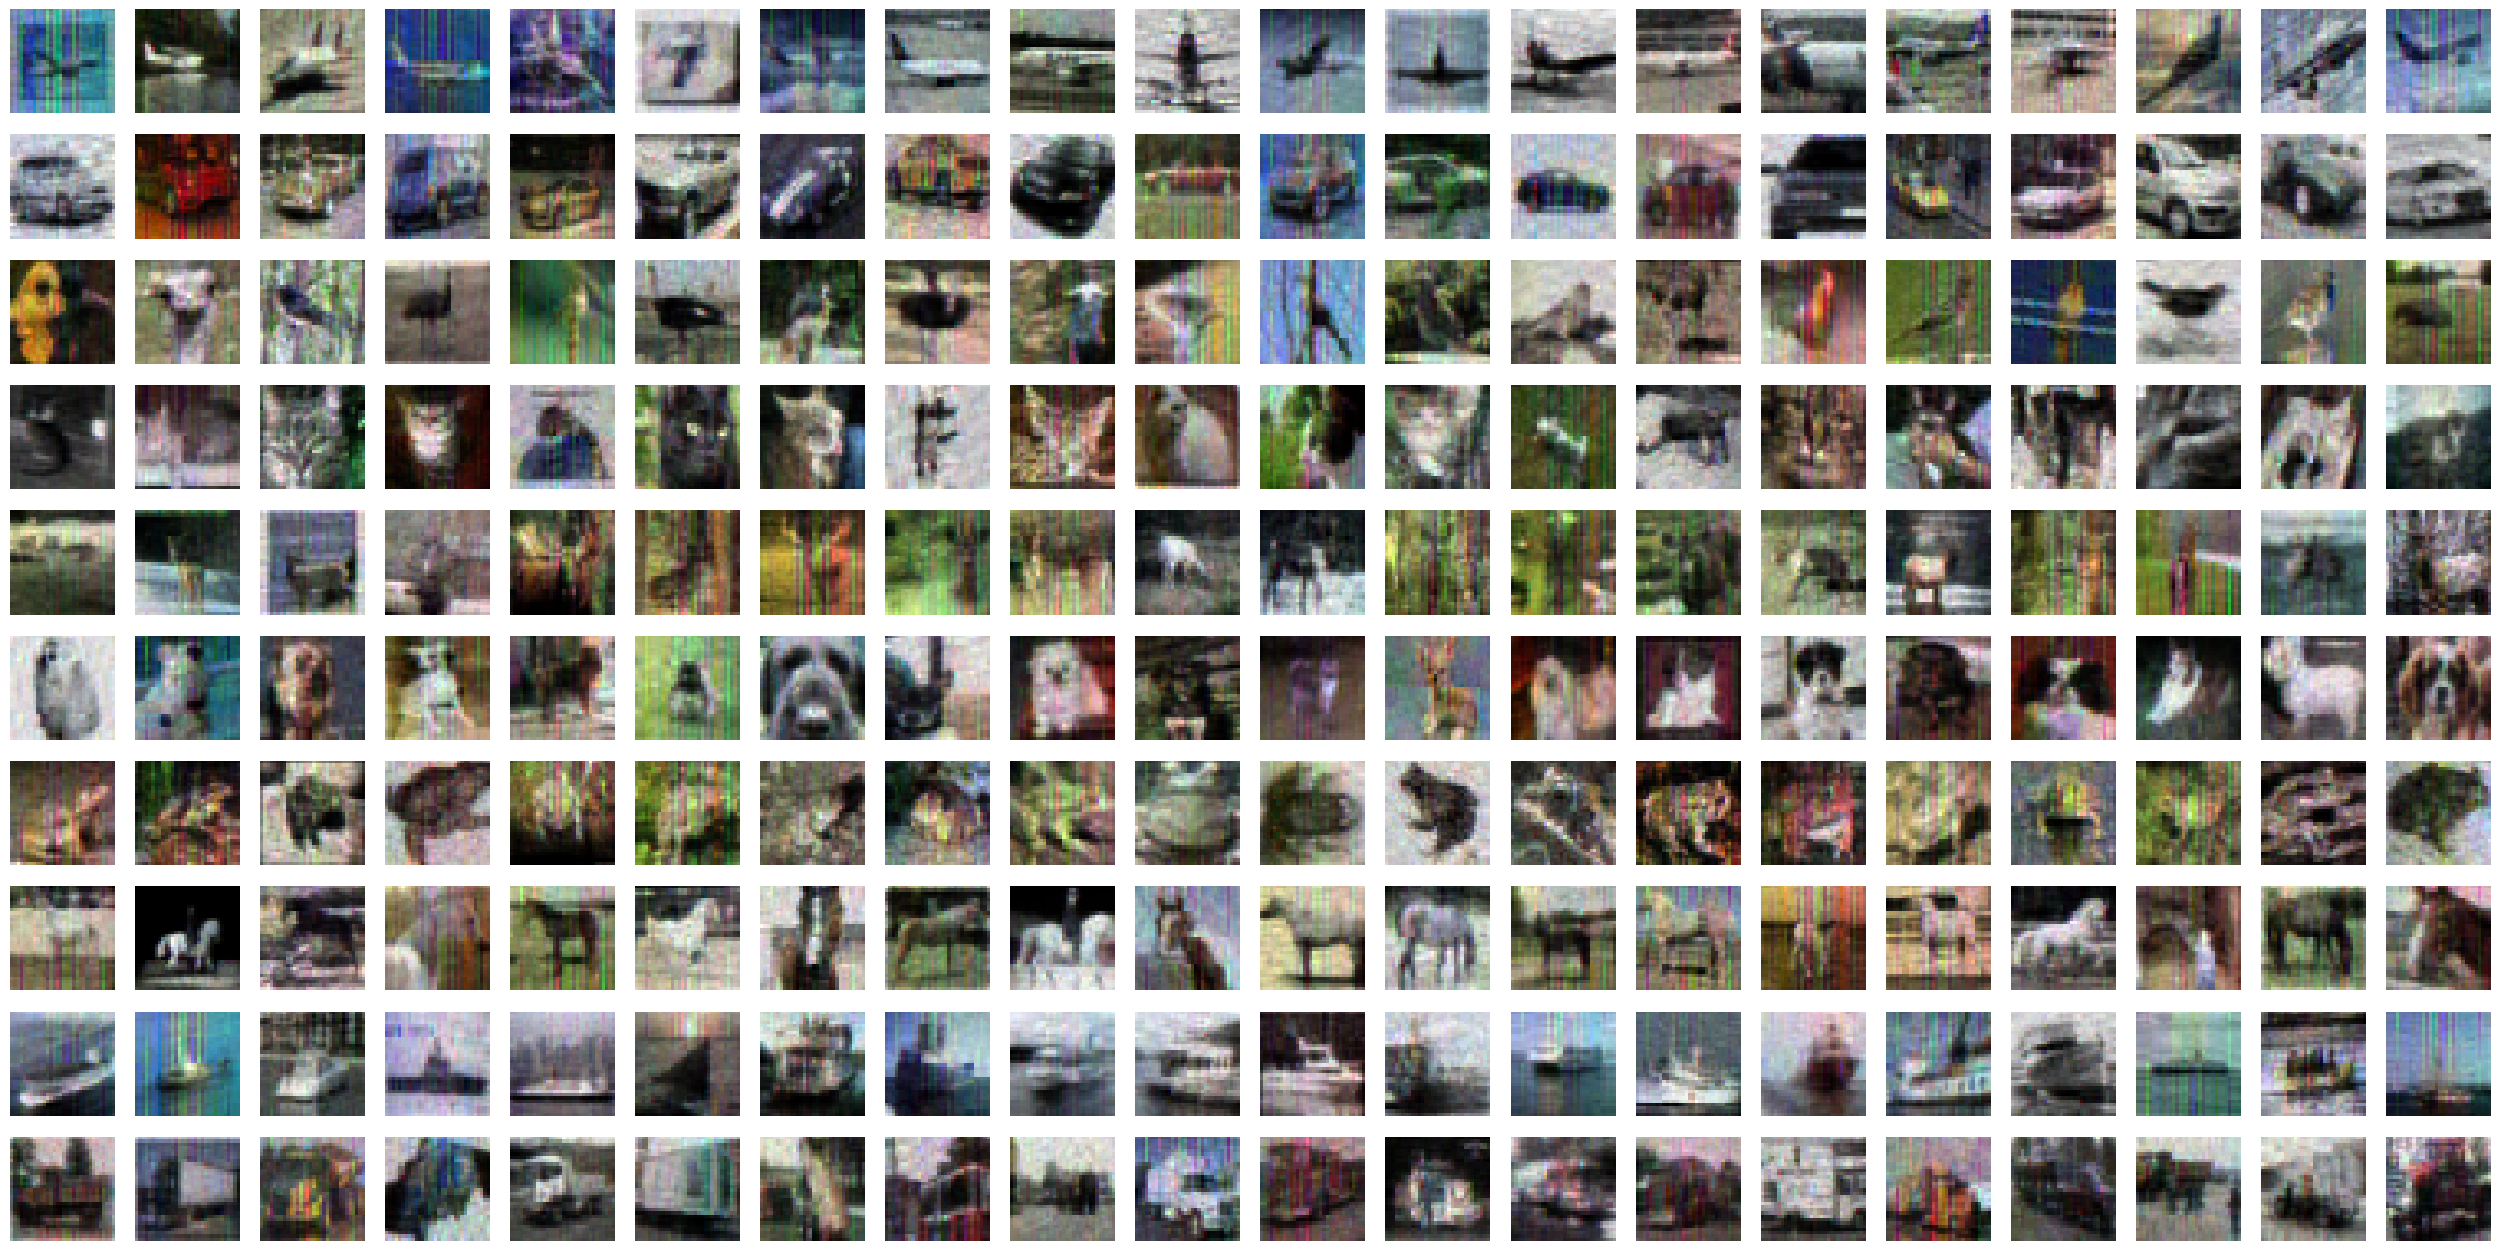

In [8]:
# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for class_ in range(num_class):
    for i in range(plot_num):
        plt.subplot(num_class, plot_num, class_ * plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_class[class_][i]).reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# plt.figure(figsize=(32, 16))
# for class_ in range(num_class):
#     for i in range(plot_num):
#         plt.subplot(num_class, plot_num, class_ * plot_num + i + 1)
#         plt.imshow(theta_class[class_][i].reshape((32, 32, 3)), cmap='coolwarm', vmin=-15, vmax=15)
#         plt.axis('off')  # Hide axes

# plt.show()

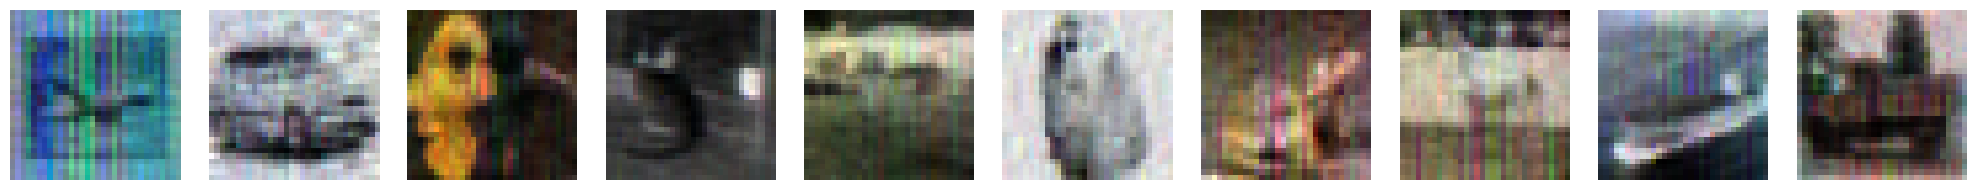

In [9]:
plt.figure(figsize=(20, 2))
for class_ in range(num_class):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, num_class, class_ * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_class[class_][i]).reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/CIFAR/default/LD.pdf', format='pdf')

plt.show()

# # Find the nearest distance between every new sample among the training set in terms of norm.
# plt.figure(figsize=(20, 2))
# for class_ in range(num_class):
#     for i in range(paper_plot_num):
#         plt.subplot(paper_plot_num, num_class, class_ * paper_plot_num + i + 1)
#         plt.imshow(theta_class[class_][i].reshape((32, 32, 3)), cmap='coolwarm', vmin=-15, vmax=15)
#         plt.axis('off')  # Hide axes

# plt.tight_layout()

# plt.savefig('../Figures/CIFAR/default/LD_parameter.pdf', format='pdf')

# plt.show()

#### Fitting on Projected Points

In [10]:
sampled_theta_class = []

for class_ in range(num_class):
    reduced_theta = vectorize_tensor(theta_class[class_], B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(reduced_theta)
    # Sample new data from the KDE
    sampled_reduced_theta = kde.sample(n_samples=new_sample_size_per_class)

    sampled_theta = reconstruct_tensor(sampled_reduced_theta, (new_sample_size_per_class, *S), B_LD)
    sampled_theta_class.append(sampled_theta)

#### Construct Local Data Sub-Manifold

In [11]:
# Construct the constrained coordinates
# B_BP = ld.block_B([14, 14], [15, 15])
B_BP = ld.default_B(S, 4, cp.get_array_module(P[0]))
print(f"Dimension of Local Data Sub-Manifold: {D - B_BP.shape[0]}")

# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat_class = []

for class_ in range(num_class):
    eta_hat_list = []
    for i in range(P_class[class_].shape[0]):
        xp = cp.get_array_module(P_class[class_][i])
        P = (P_class[class_][i] + eps) / scaleX_class[class_][i]
        eta_hat = ld.get_eta(P, len(S), xp)
        eta_hat_list.append(eta_hat)

    eta_hat_class.append(cp.asarray(eta_hat_list))

Dimension of Local Data Sub-Manifold: 2334


#### Backward Projection

In [12]:
if load:
    # Load all intermediate results from disk
    results_BP = np.load('results_BP.npz')
    sampled_P_BP_class = results_BP['sampled_P_BP_class']
    sampled_theta_BP_class = results_BP['sampled_theta_BP_class']
    sampled_X_BP_class = results_BP['sampled_X_BP_class']
else:
    # Use a custom temporary directory
    import tempfile
    temp_dir = tempfile.mkdtemp(dir='/data/pbb/tmp')


    def BP_helper(i, class_):
        N = ld.kNN(sampled_theta_class[class_][i], theta_class[class_], k=k)
        avg_scale = np.mean(scaleX_class[class_][N])
        avg_eta_hat = np.mean(eta_hat_class[class_][N], axis=0)
        _, _, P, theta = ld.BP(sampled_theta_class[class_][i], [(P_class[class_][j] + eps) / scaleX_class[class_][j] for j in N], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=1e-1)
        X_recons_ = (P).astype(np.int32).reshape(-1)
        return (P, theta, X_recons_)

    results = Parallel(n_jobs=30, temp_folder=temp_dir)(delayed(BP_helper)(i, class_) for i in range(new_sample_size_per_class) for class_ in range(num_class))

    sampled_P_BP_class = []
    sampled_theta_BP_class = []
    sampled_X_BP_class = []

    for class_ in range(num_class):
        sampled_P_BP = []
        sampled_theta_BP = []
        sampled_X_BP = []
        for i in range(new_sample_size_per_class):
            result = results[i*num_class + class_]

            sampled_P_BP.append(result[0])
            sampled_theta_BP.append(result[1])
            sampled_X_BP.append(result[2])

        sampled_P_BP_class.append(np.array(sampled_P_BP))
        sampled_theta_BP_class.append(np.array(sampled_theta_BP))
        sampled_X_BP_class.append(np.array(sampled_X_BP))

    np.savez('results_BP.npz', sampled_P_BP_class=sampled_P_BP_class, sampled_theta_BP_class=sampled_theta_BP_class, sampled_X_BP_class=sampled_X_BP_class)

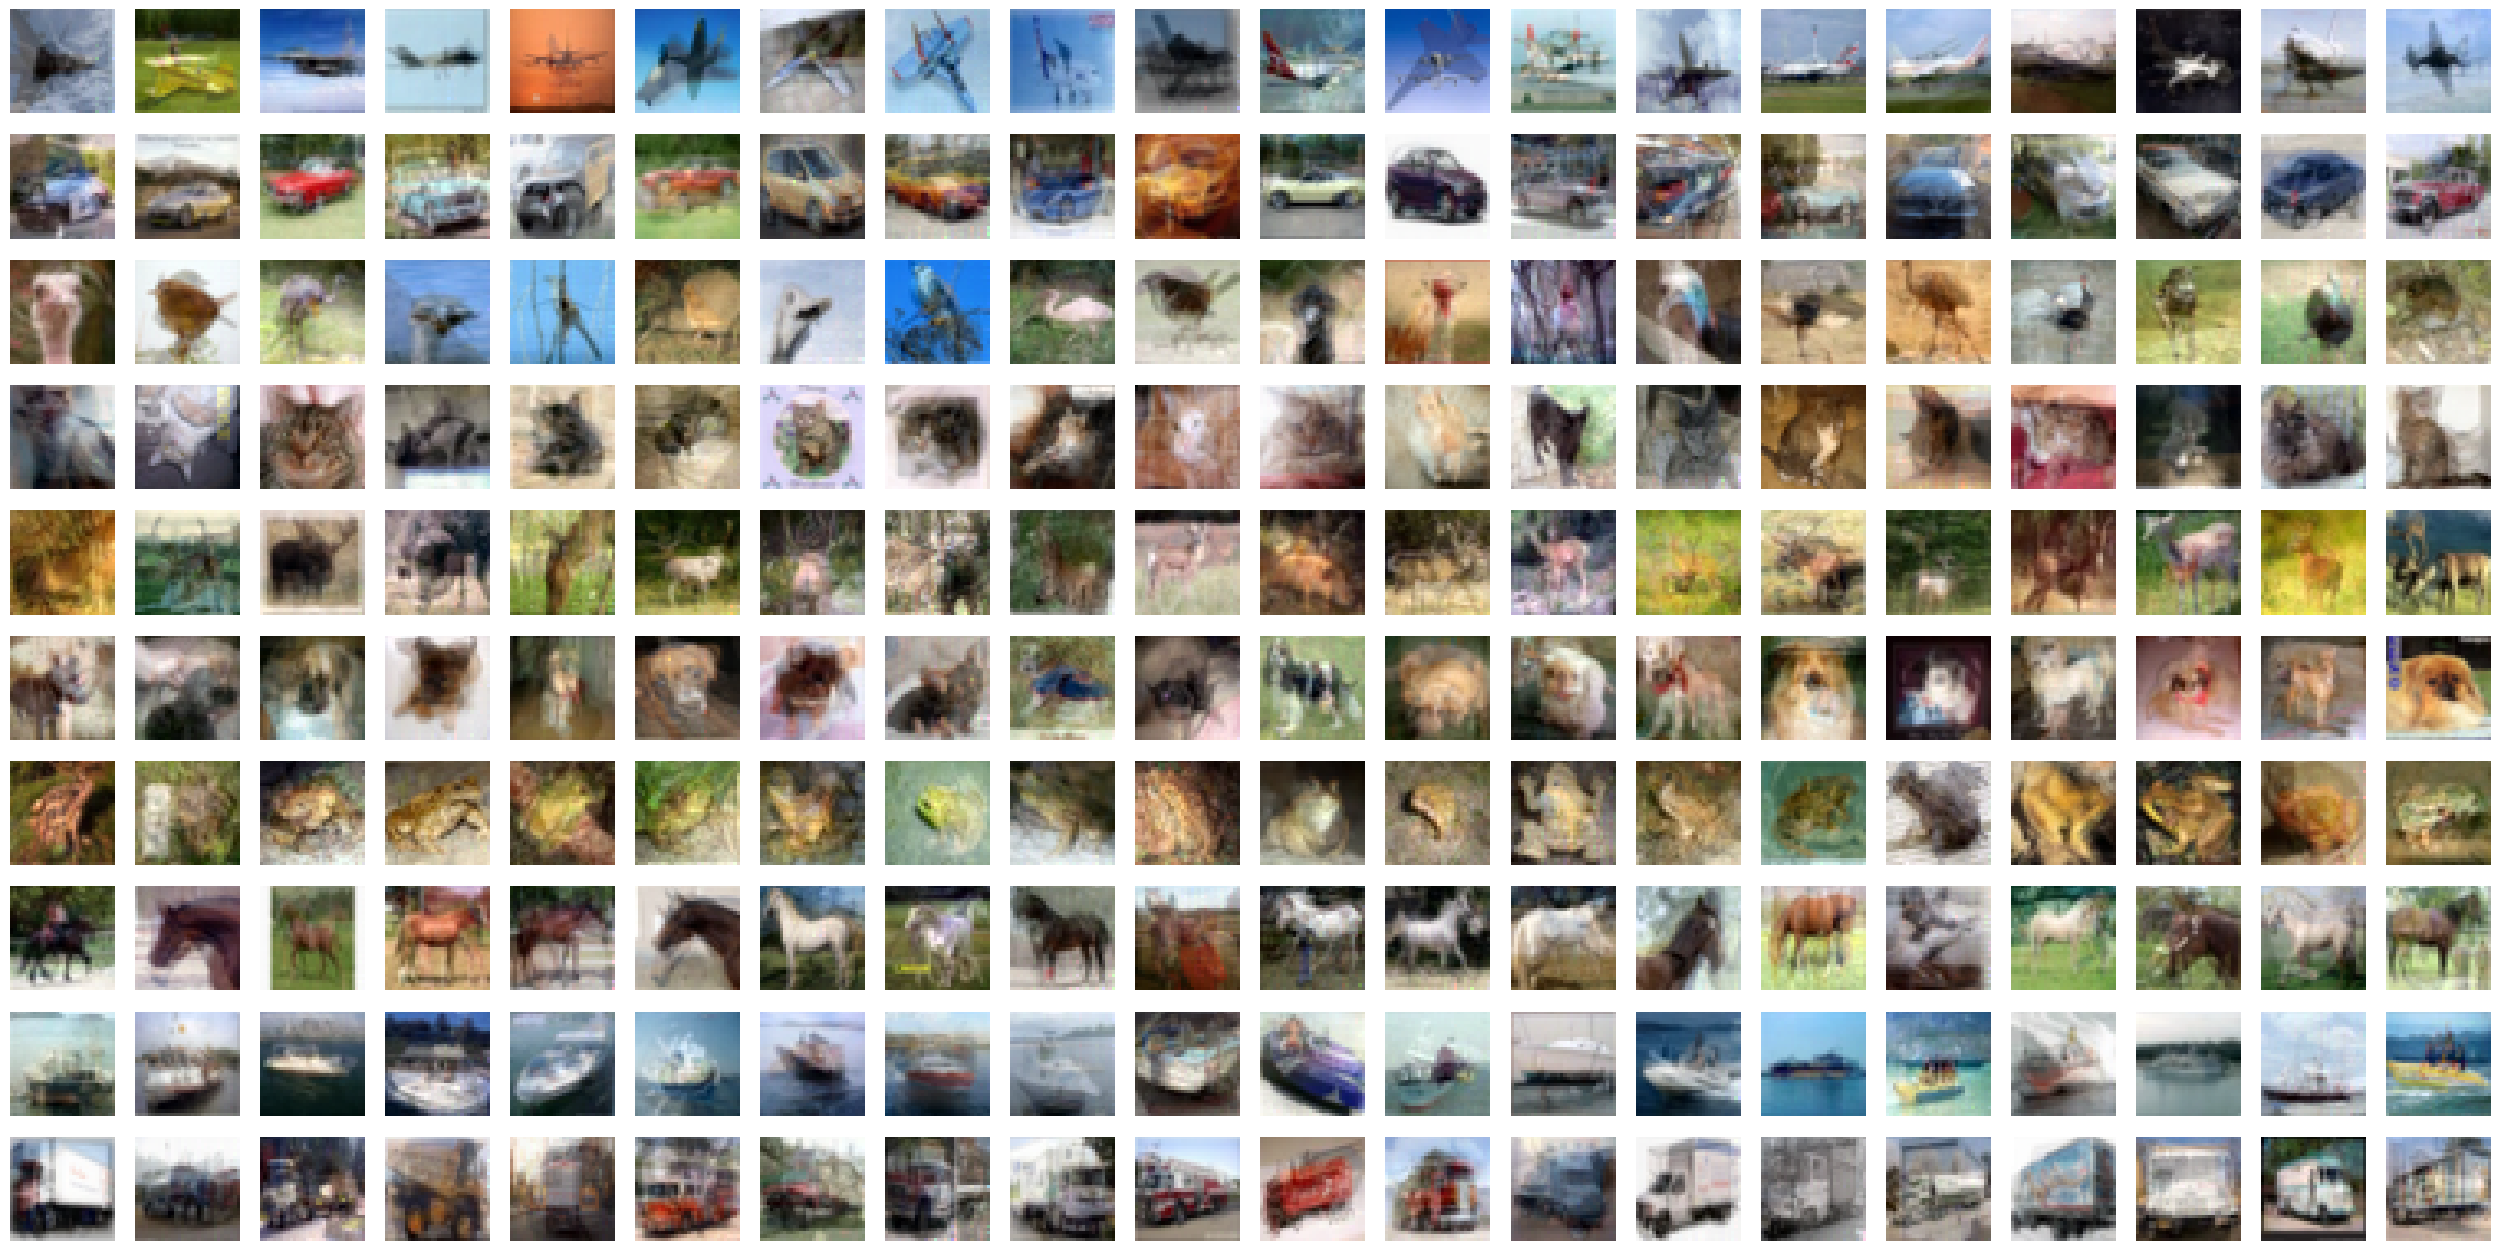

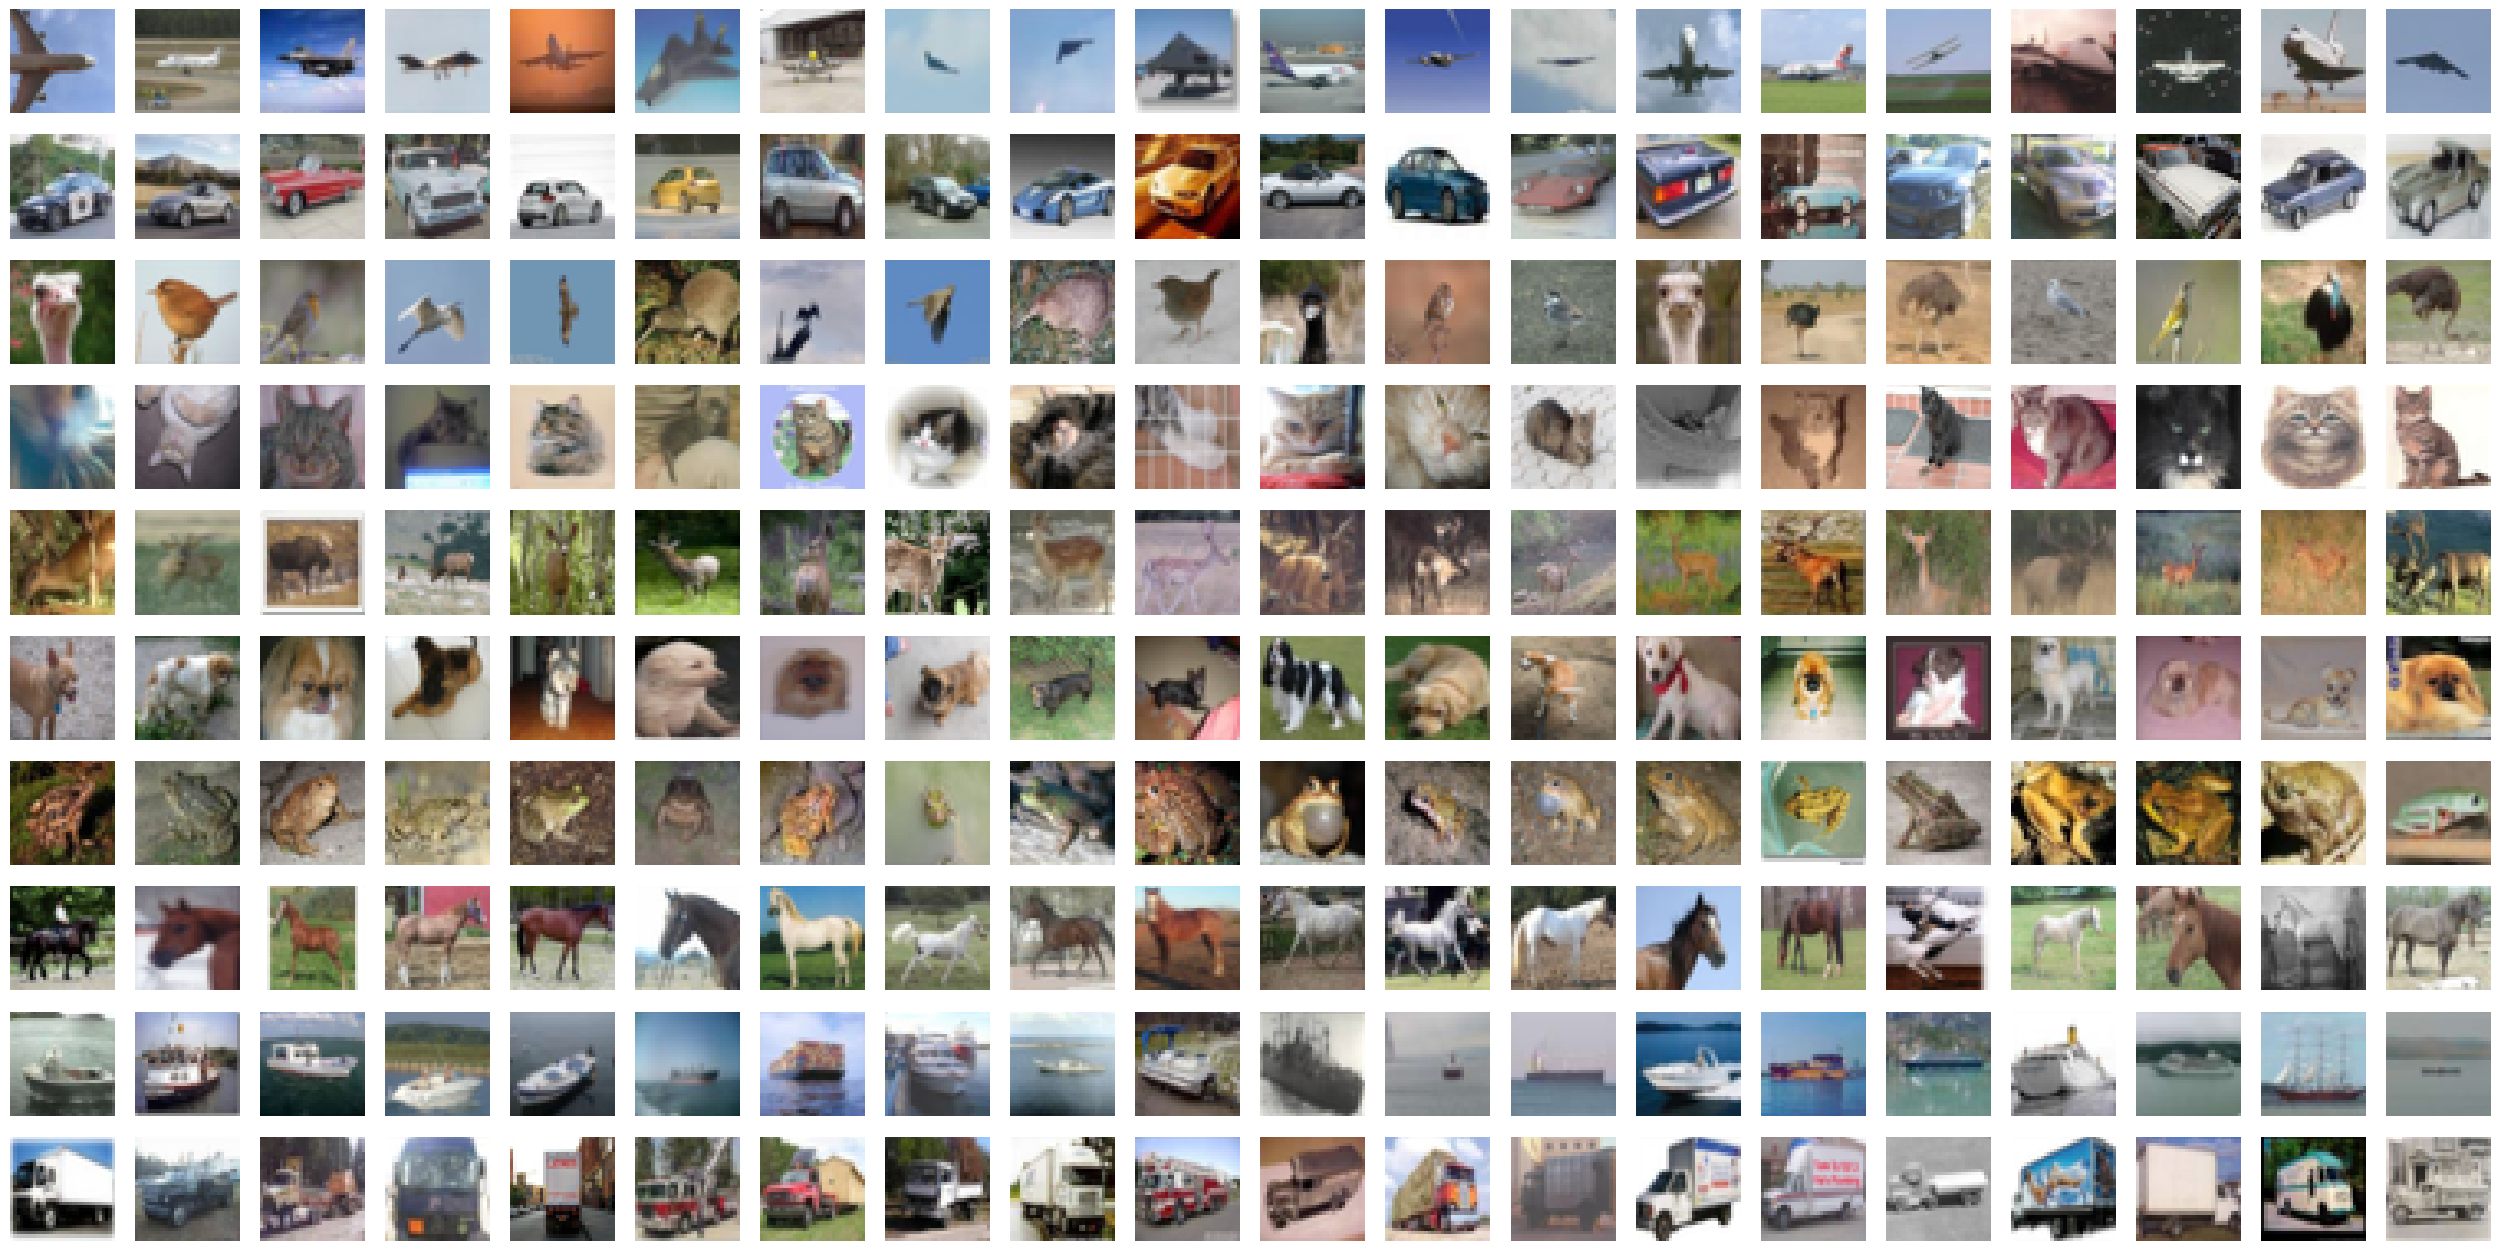

In [13]:
plt.figure(figsize=(32, 16))
for class_ in range(num_class):
    for i in range(plot_num):
        plt.subplot(num_class, plot_num, class_ * plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_BP_class[class_][i]).reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for class_ in range(num_class):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_X_BP_class[class_][i].reshape((32, 32, 3)) - p.reshape((32, 32, 3))) for p in P_class[class_]]
        idx = np.argmin(norm)
        plt.subplot(num_class, plot_num, class_ * plot_num + i + 1)
        plt.imshow(P_class[class_][idx].reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

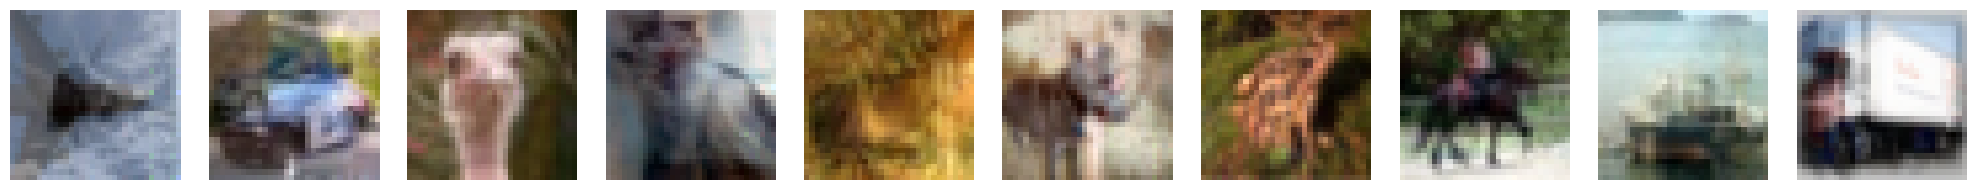

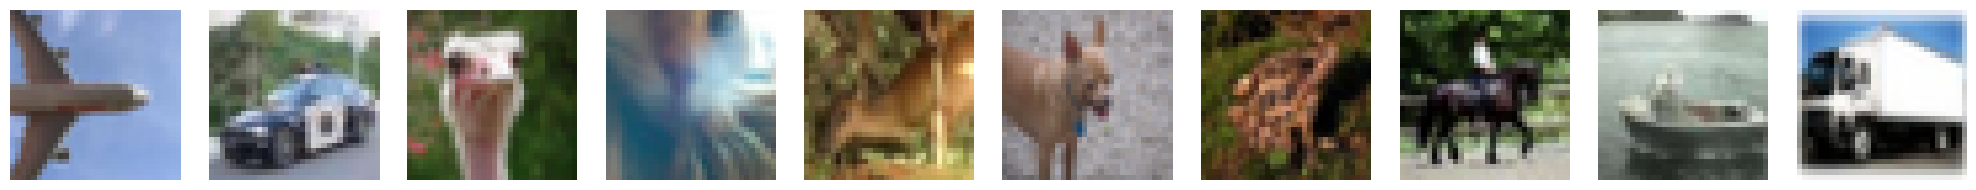

In [14]:
plt.figure(figsize=(20, 2))
for class_ in range(num_class):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, num_class, class_ * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_BP_class[class_][i]).reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/CIFAR/default/BP.pdf', format='pdf')

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for class_ in range(num_class):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_X_BP_class[class_][i].reshape((32, 32, 3)) - p.reshape((32, 32, 3))) for p in P_class[class_]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, num_class, class_ * paper_plot_num + i + 1)
        plt.imshow(P_class[class_][idx].reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/CIFAR/default/BP_compare.pdf', format='pdf')

plt.show()

## Data Augmentation with Autoencoder

Some remark on the Autoencoder architecture and training for CIFAR-10 specifically:
1. The training set should **not** be normalize in order to obtain a good result.
2. Since we're now dealing with colored images, more careful permutation is required.

Due the the above, the data processing pipeline is slightly different from MNIST.

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_channels=3, feature_maps=[12, 24, 48]):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_channels, feature_maps[0], kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(feature_maps[0], feature_maps[1], kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(feature_maps[1], feature_maps[2], kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layers(x)


class Decoder(nn.Module):
    def __init__(self, output_channels=3, feature_maps=[48, 24, 12]):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(feature_maps[0], feature_maps[1], kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_maps[1], feature_maps[2], kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_maps[2], output_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

Files already downloaded and verified


  4%|▍         | 4/100 [00:28<11:28,  7.17s/it]

100%|██████████| 100/100 [12:15<00:00,  7.36s/it]


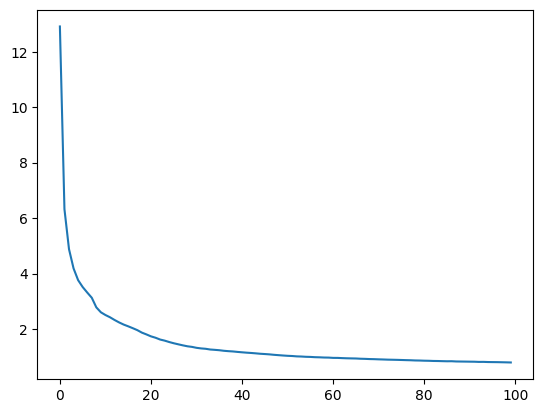

In [16]:
train_loader_original = DataLoader(dataset=datasets.CIFAR10(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor(), ])), batch_size=64, shuffle=True)

enc = Encoder(input_channels=3, feature_maps=[12, 24, 48]).to(device)
dec = Decoder(output_channels=3, feature_maps=[48, 24, 12]).to(device)
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters(), lr=1e-3)
optimizer_dec = torch.optim.Adam(dec.parameters(), lr=1e-3)

train_loss = []
num_epochs = 100

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = 0
    for imgs, _ in train_loader_original:
        imgs = imgs.to(device)

        # Forward pass
        latents = enc(imgs)  # Encode to latent space
        output = dec(latents)  # Reconstruct image

        # Compute loss
        loss = loss_fn(output, imgs)
        train_epoch_loss += loss.item()

        # Backpropagation
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
    train_loss.append(train_epoch_loss)

plt.plot(train_loss)

In [17]:
representation = None
AE_imgs = None
all_labels = []

with torch.no_grad():
    for (imgs , labels) in train_loader_original:
        imgs = imgs.to(device)

        all_labels.extend(list(labels.numpy()))
        latents = enc(imgs)
        if representation is None:
            representation = latents.cpu()
        else:
            representation = torch.vstack([representation , latents.cpu()])

        imgs = imgs.permute(0, 2, 3, 1)
        if AE_imgs is None:
            AE_imgs = imgs.detach().cpu().numpy()
        else:
            AE_imgs = np.vstack([AE_imgs , imgs.detach().cpu().numpy()])

AE_class = []
for class_ in range(num_class):
    AE_class.append(AE_imgs[torch.tensor(all_labels) == class_])

all_labels = np.array(all_labels)
representation = representation.numpy()

In [18]:
representation_flatten = representation.reshape(50000, -1)
sampled_X_AE_class = []

for class_ in range(num_class):
    sampled_X_AE_list = []
    rep = representation_flatten[np.argwhere(all_labels == class_)].squeeze()

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_AE).fit(rep)

    # Sample new data from the KDE
    sampled_rep = kde.sample(n_samples=new_sample_size_per_class)

    sampled_rep = sampled_rep.reshape(-1, *representation.shape[1:])
    for i in range(new_sample_size_per_class):
        pred = dec(torch.Tensor(sampled_rep[i]).to(device)).permute(1, 2, 0).cpu().detach().numpy()
        sampled_X_AE_list.append(pred)

    sampled_X_AE_class.append(sampled_X_AE_list)

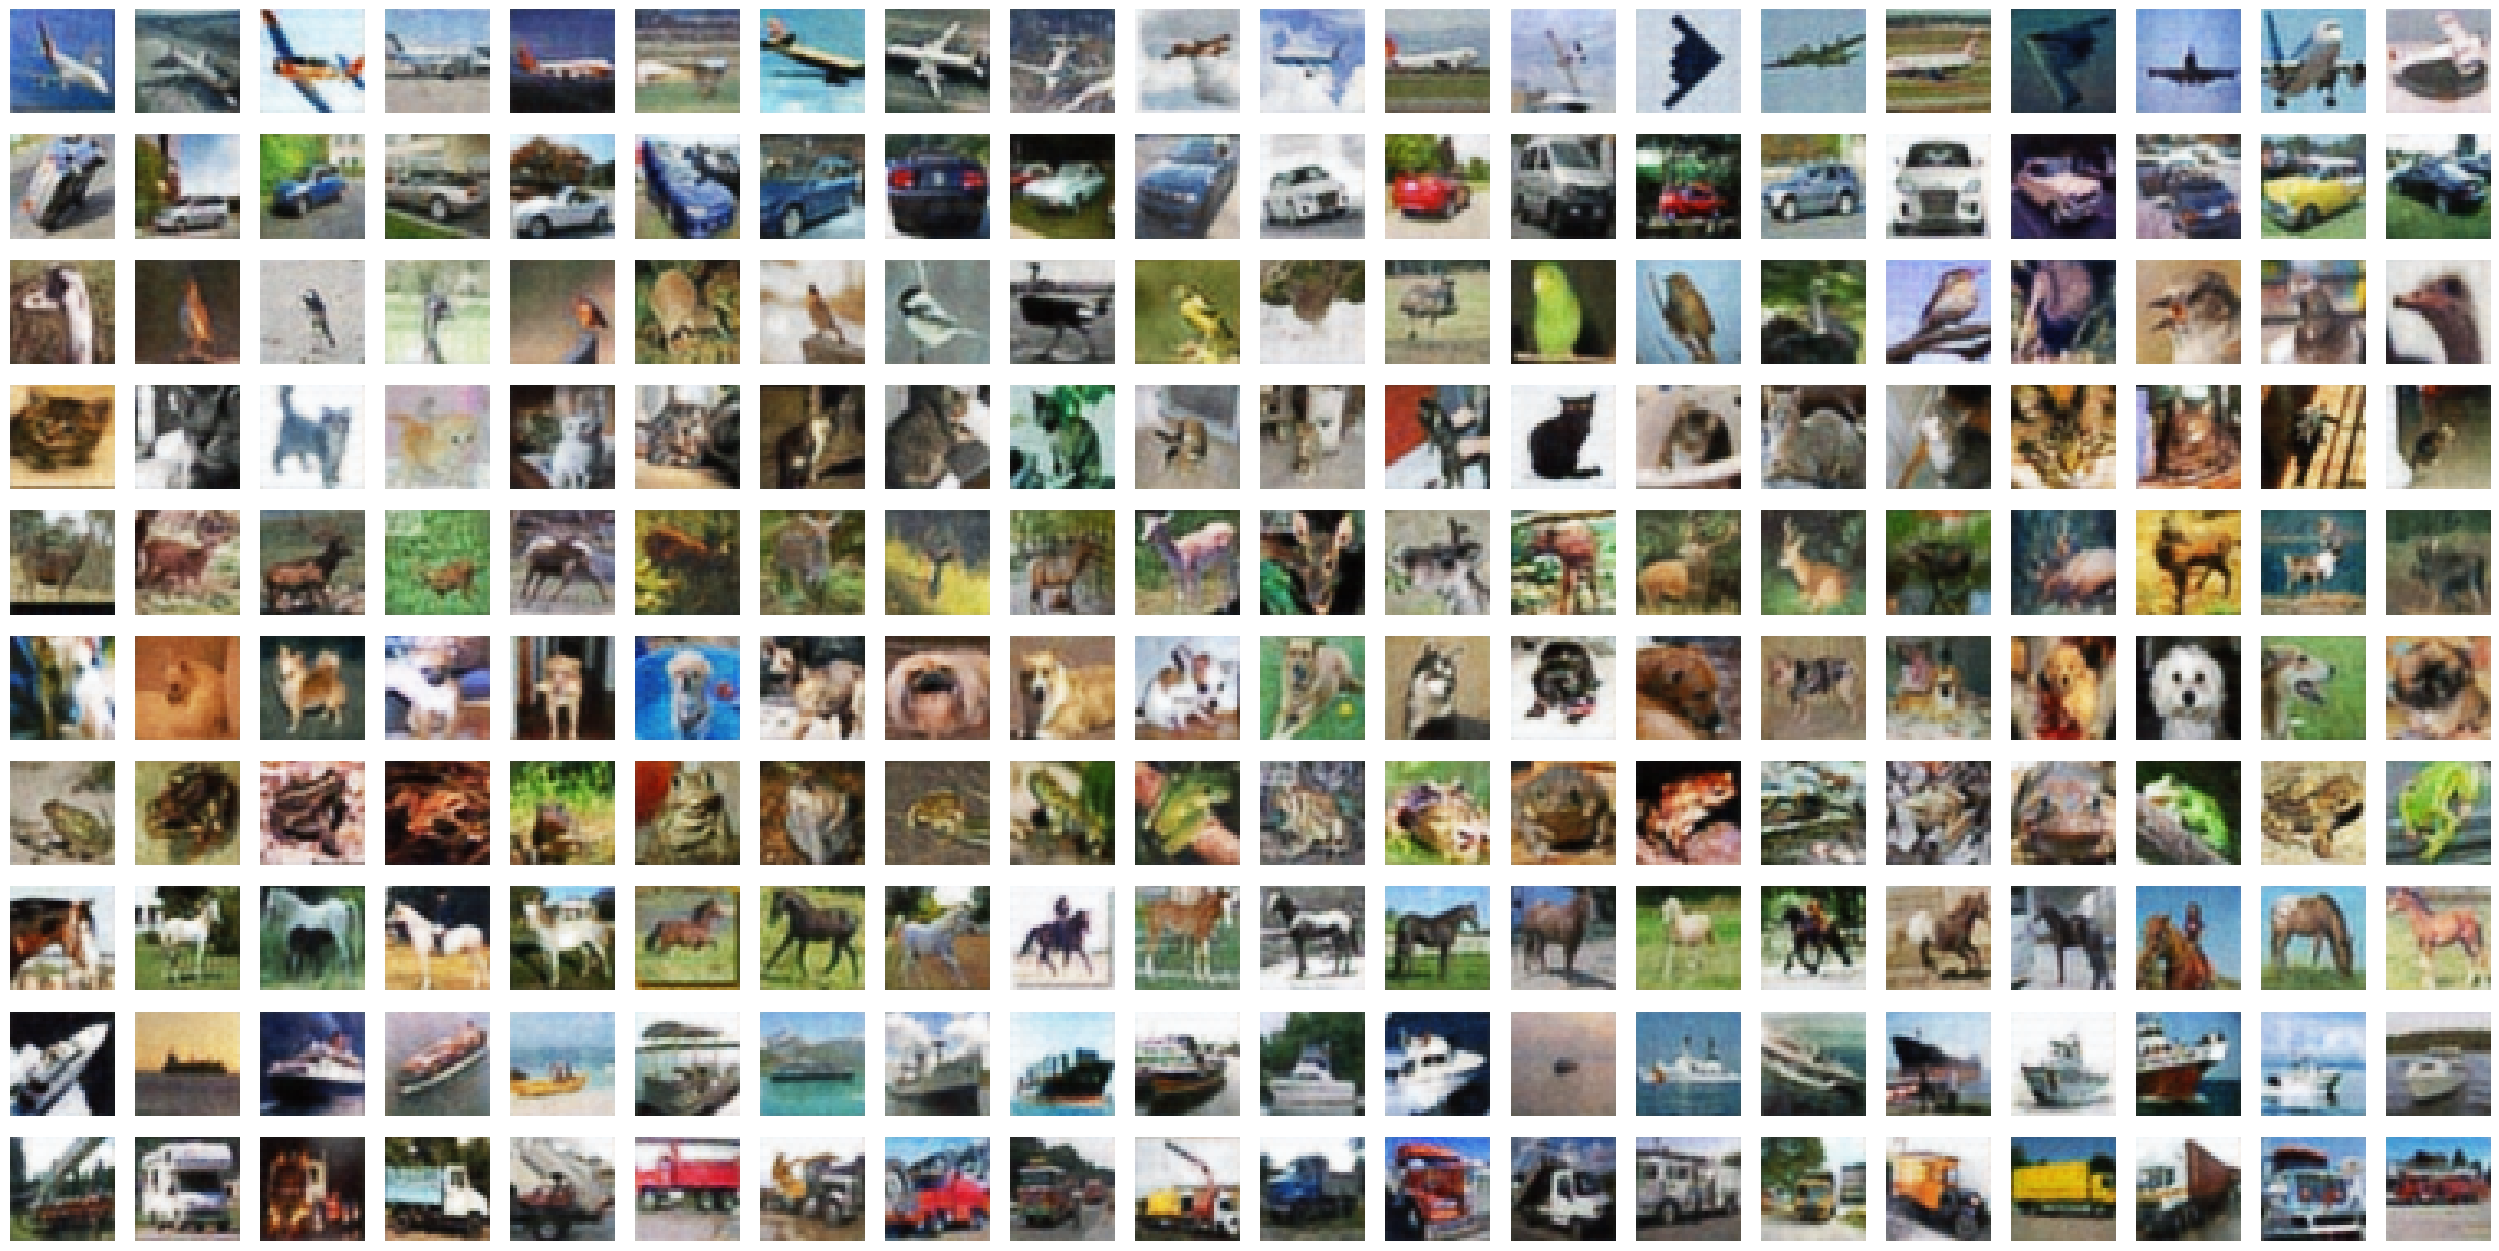

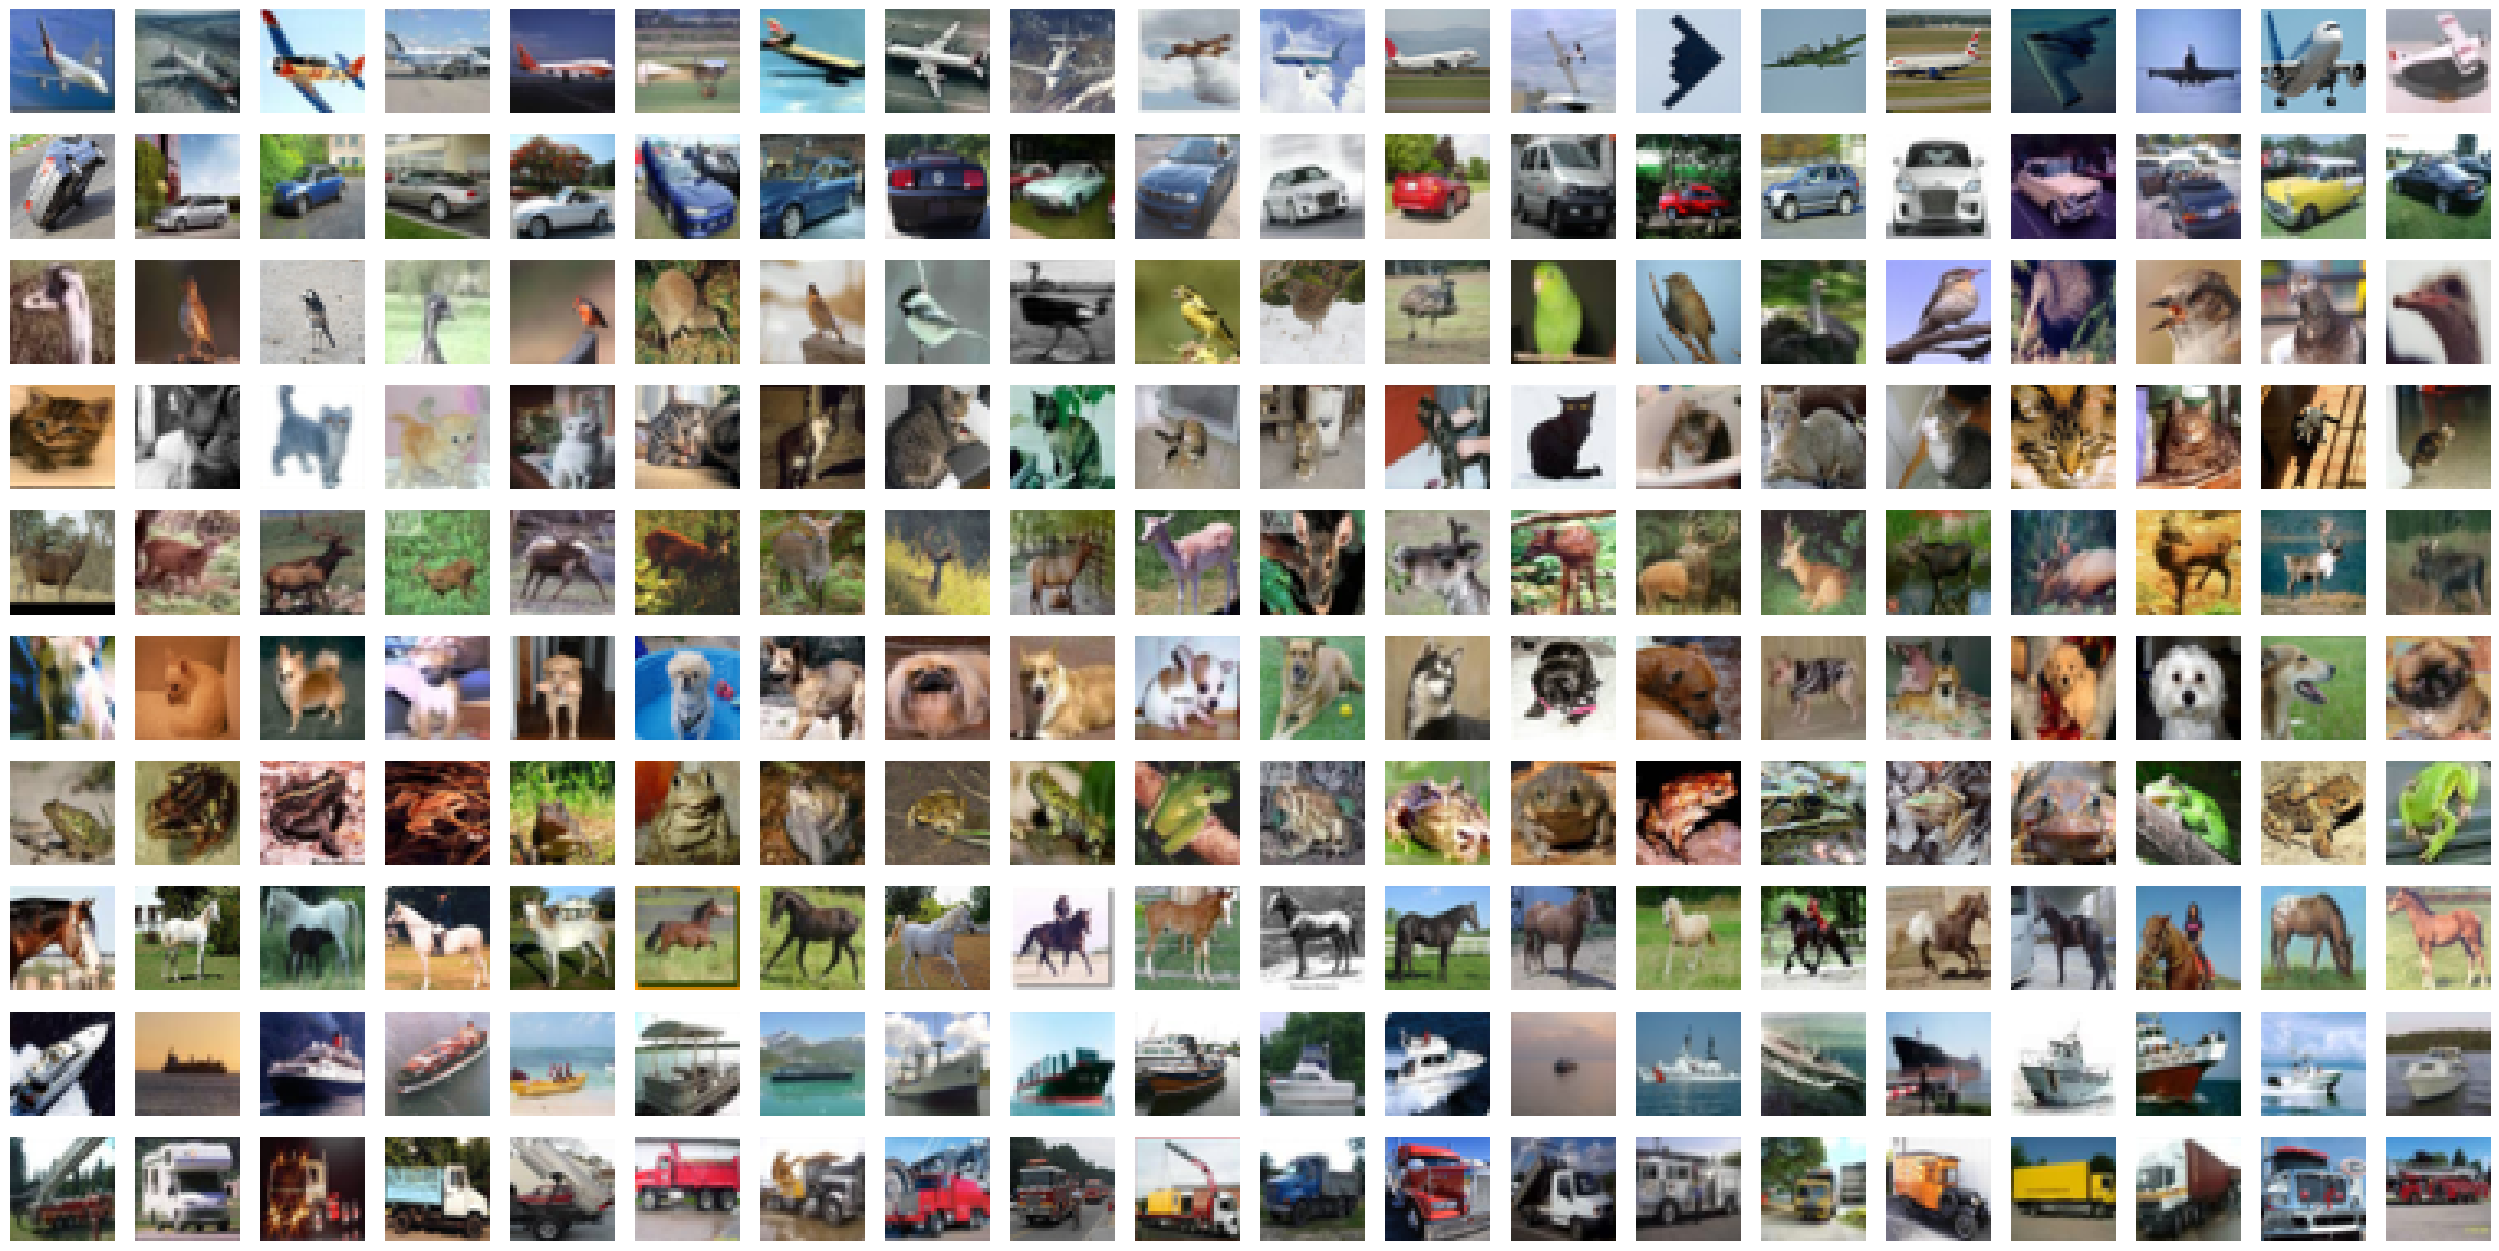

In [19]:
plt.figure(figsize=(32, 16))
for class_ in range(num_class):
    for i in range(plot_num):
        plt.subplot(num_class, plot_num, class_ * plot_num + i + 1)
        plt.imshow(sampled_X_AE_class[class_][i], cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for class_ in range(num_class):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_X_AE_class[class_][i] - p) for p in AE_class[class_]]
        idx = np.argmin(norm)
        plt.subplot(num_class, plot_num, class_ * plot_num + i + 1)
        plt.imshow(AE_class[class_][idx], cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

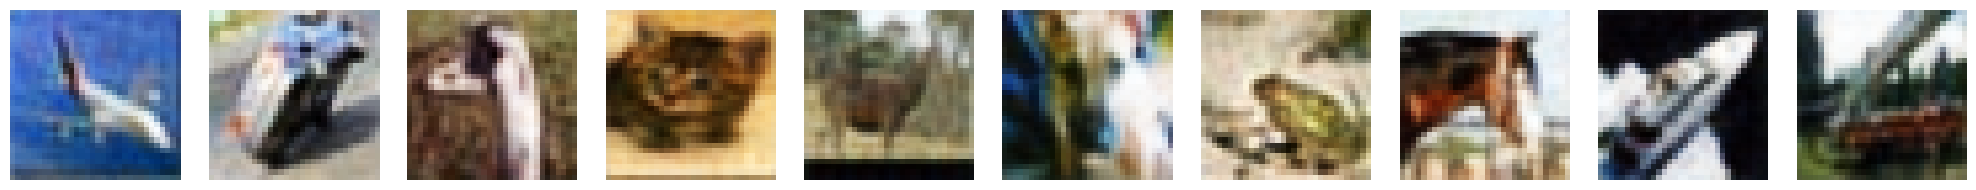

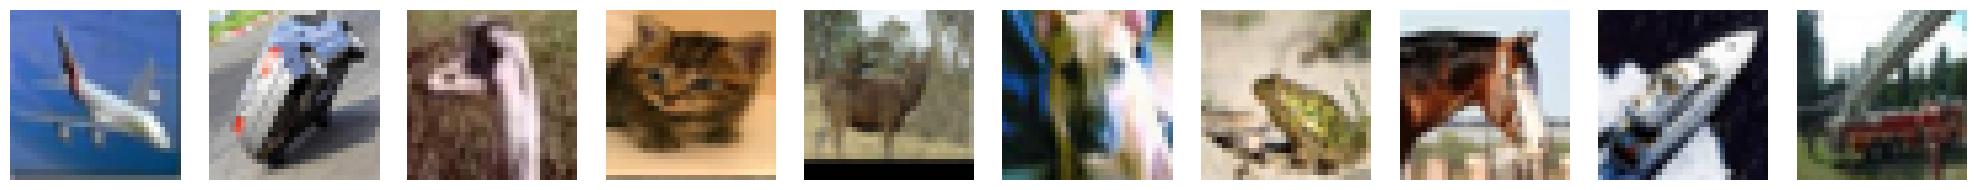

In [20]:
plt.figure(figsize=(20, 2))
for class_ in range(num_class):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, num_class, class_ * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_AE_class[class_][i]).reshape(32, 32, 3), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/CIFAR/else/AE.pdf', format='pdf')

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for class_ in range(num_class):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_X_AE_class[class_][i].reshape((32, 32, 3)) - p.reshape((32, 32, 3))) for p in AE_class[class_]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, num_class, class_ * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(AE_class[class_][idx]).reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/CIFAR/else/AE_compare.pdf', format='pdf')

plt.show()

## Classification Performance

### Dataset Preparation

In [21]:
# Helper function to create a DataLoader for augmented datasets
def prepare_augmented_dataset(original_dataset, augmented_data, augmented_labels, transform, batch_size):
    # Create dataset from augmented data
    augmented_dataset = NumpyDataset(data=augmented_data, labels=augmented_labels, transform=transform)

    # Combine with the original CIFAR-10 dataset
    combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

    # Create a DataLoader for the combined dataset
    return DataLoader(dataset=combined_dataset, batch_size=batch_size, shuffle=True)

# Main function to prepare datasets and loaders
def create_datasets_and_loaders(batch_size=64):
    # Transformations
    transform_standard = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ])
    transform_none = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ])
    transform_none_augmented = transforms.Compose([
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ])

    # CIFAR-10 Datasets
    cifar_train_standard = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_standard)
    cifar_train_none = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_none)

    augmented_data_PNL = []
    labels_PNL = []
    augmented_data_AE = []
    labels_AE = []

    for class_ in range(num_class):
        for img_PNL in sampled_X_BP_class[class_]:
            augmented_data_PNL.append(renormalize_image(img_PNL).reshape((32, 32, 3)))
            labels_PNL.append(class_)

        for img_AE in sampled_X_AE_class[class_]:
            augmented_data_AE.append(img_AE)
            labels_AE.append(class_)

    augmented_data_PNL = np.array(augmented_data_PNL)
    labels_PNL = np.array(labels_PNL)
    augmented_data_AE = np.array(augmented_data_AE)
    labels_AE = np.array(labels_AE)

    # Combine CIFAR-10 with augmented data
    train_loader_PNL = prepare_augmented_dataset(cifar_train_none, augmented_data_PNL, labels_PNL, transform_none_augmented, batch_size)
    train_loader_AE = prepare_augmented_dataset(cifar_train_none, augmented_data_AE, labels_AE, transform_none_augmented, batch_size)

    # DataLoader for CIFAR-10 only
    train_loader_standard = DataLoader(cifar_train_standard, batch_size=batch_size, shuffle=True)
    train_loader_none = DataLoader(cifar_train_none, batch_size=batch_size, shuffle=True)

    return {
        "standard": train_loader_standard,
        "none": train_loader_none,
        "PNL_augmented": train_loader_PNL,
        "AE_augmented": train_loader_AE,
    }

loaders = create_datasets_and_loaders(batch_size=64)

# Check each DataLoader
for name, loader in loaders.items():
    print(f"{name} loader:")
    for images, labels in loader:
        print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
        break

train_loader_standard = loaders["standard"]
train_loader_none = loaders["none"]
train_loader_PNL = loaders["PNL_augmented"]
train_loader_AE = loaders["AE_augmented"]

Files already downloaded and verified
Files already downloaded and verified
standard loader:
Images shape: torch.Size([64, 3, 32, 32]), Labels shape: torch.Size([64])
none loader:
Images shape: torch.Size([64, 3, 32, 32]), Labels shape: torch.Size([64])
PNL_augmented loader:
Images shape: torch.Size([64, 3, 32, 32]), Labels shape: torch.Size([64])
AE_augmented loader:
Images shape: torch.Size([64, 3, 32, 32]), Labels shape: torch.Size([64])


### ResNet18 Model

In [22]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=False)  # Load ResNet18
        # Adjust first convolution for CIFAR-10
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.maxpool = nn.Identity()  # Remove max-pooling layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # Adjust for CIFAR-10 classes

    def forward(self, x):
        return self.resnet(x)

def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device='cuda'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()  # Adjust learning rate
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

def test_model(model, test_loader, device='cuda'):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def bootstrapping(train_loader, test_dataset, num_epochs=100, learning_rate=1e-1, n_bootstrap=20, device='cuda'):
    """
    Train the ResNet model on the training dataset, and evaluate it using bootstrapping on the test dataset.

    Args:
        train_loader: DataLoader for training data.
        test_dataset: Dataset object for the test data.
        num_epochs: Number of epochs for training.
        learning_rate: Learning rate for the optimizer.
        device: Device to run the training on ('cuda' or 'cpu').

    Returns:
        Prints the mean accuracy and 95% confidence interval after bootstrapping.
    """
    # Initialize the model, loss, optimizer, and scheduler
    model = ResNetModel(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Decay LR every 30 epochs

    # Train the model
    train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=num_epochs, device=device)

    # Perform bootstrapping
    accuracies = []

    num_test_samples = len(test_dataset) // 2
    for i in range(n_bootstrap):
        indices = torch.randint(len(test_dataset), size=(num_test_samples,))  # Sample 500 random indices
        bootstrap_subset = Subset(test_dataset, indices)
        bootstrap_loader = DataLoader(dataset=bootstrap_subset, batch_size=num_test_samples, shuffle=False)

        accuracy = test_model(model, bootstrap_loader, device=device)
        accuracies.append(accuracy)

    # Compute statistics
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print(f"Mean accuracy: {mean_accuracy:.2f}%")
    print(f"Standard deviation: {std_accuracy:.2f}")

### Dataset Performance

In [23]:
bootstrapping(train_loader_none, test_dataset, num_epochs=50, learning_rate=0.1, device=device)

Epoch [1/50], Loss: 1.8750
Epoch [2/50], Loss: 1.2761
Epoch [3/50], Loss: 0.9668
Epoch [4/50], Loss: 0.7729
Epoch [5/50], Loss: 0.6599
Epoch [6/50], Loss: 0.5906
Epoch [7/50], Loss: 0.5457
Epoch [8/50], Loss: 0.5065
Epoch [9/50], Loss: 0.4800
Epoch [10/50], Loss: 0.4592
Epoch [11/50], Loss: 0.4424
Epoch [12/50], Loss: 0.4265
Epoch [13/50], Loss: 0.4195
Epoch [14/50], Loss: 0.4101
Epoch [15/50], Loss: 0.3935
Epoch [16/50], Loss: 0.3960
Epoch [17/50], Loss: 0.3884
Epoch [18/50], Loss: 0.3868
Epoch [19/50], Loss: 0.3753
Epoch [20/50], Loss: 0.3684
Epoch [21/50], Loss: 0.3723
Epoch [22/50], Loss: 0.3698
Epoch [23/50], Loss: 0.3686
Epoch [24/50], Loss: 0.3627
Epoch [25/50], Loss: 0.3629
Epoch [26/50], Loss: 0.3617
Epoch [27/50], Loss: 0.3539
Epoch [28/50], Loss: 0.3557
Epoch [29/50], Loss: 0.3523
Epoch [30/50], Loss: 0.3534
Epoch [31/50], Loss: 0.1107
Epoch [32/50], Loss: 0.0352
Epoch [33/50], Loss: 0.0153
Epoch [34/50], Loss: 0.0089
Epoch [35/50], Loss: 0.0062
Epoch [36/50], Loss: 0.0049
E

In [24]:
bootstrapping(train_loader_standard, test_dataset, num_epochs=50, learning_rate=0.1, device=device)

Epoch [1/50], Loss: 1.8027


Epoch [2/50], Loss: 1.2781
Epoch [3/50], Loss: 0.9980
Epoch [4/50], Loss: 0.8185
Epoch [5/50], Loss: 0.7303
Epoch [6/50], Loss: 0.6783
Epoch [7/50], Loss: 0.6469
Epoch [8/50], Loss: 0.6274
Epoch [9/50], Loss: 0.6030
Epoch [10/50], Loss: 0.5855
Epoch [11/50], Loss: 0.5684
Epoch [12/50], Loss: 0.5608
Epoch [13/50], Loss: 0.5543
Epoch [14/50], Loss: 0.5516
Epoch [15/50], Loss: 0.5422
Epoch [16/50], Loss: 0.5359
Epoch [17/50], Loss: 0.5258
Epoch [18/50], Loss: 0.5277
Epoch [19/50], Loss: 0.5218
Epoch [20/50], Loss: 0.5166
Epoch [21/50], Loss: 0.5174
Epoch [22/50], Loss: 0.5150
Epoch [23/50], Loss: 0.5078
Epoch [24/50], Loss: 0.5129
Epoch [25/50], Loss: 0.5055
Epoch [26/50], Loss: 0.5049
Epoch [27/50], Loss: 0.4941
Epoch [28/50], Loss: 0.4923
Epoch [29/50], Loss: 0.4952
Epoch [30/50], Loss: 0.4904
Epoch [31/50], Loss: 0.2828
Epoch [32/50], Loss: 0.2246
Epoch [33/50], Loss: 0.1978
Epoch [34/50], Loss: 0.1803
Epoch [35/50], Loss: 0.1667
Epoch [36/50], Loss: 0.1571
Epoch [37/50], Loss: 0.1507


In [27]:
bootstrapping(train_loader_PNL, test_dataset, num_epochs=100, learning_rate=0.01, device=device)

Epoch [1/100], Loss: 1.2843
Epoch [2/100], Loss: 0.7357
Epoch [3/100], Loss: 0.5029
Epoch [4/100], Loss: 0.3521
Epoch [5/100], Loss: 0.2443
Epoch [6/100], Loss: 0.1680
Epoch [7/100], Loss: 0.1237
Epoch [8/100], Loss: 0.1059
Epoch [9/100], Loss: 0.0728
Epoch [10/100], Loss: 0.0608
Epoch [11/100], Loss: 0.0655
Epoch [12/100], Loss: 0.0608
Epoch [13/100], Loss: 0.0465
Epoch [14/100], Loss: 0.0587
Epoch [15/100], Loss: 0.0546
Epoch [16/100], Loss: 0.0460
Epoch [17/100], Loss: 0.0320
Epoch [18/100], Loss: 0.0392
Epoch [19/100], Loss: 0.0527
Epoch [20/100], Loss: 0.0554
Epoch [21/100], Loss: 0.0480
Epoch [22/100], Loss: 0.0429
Epoch [23/100], Loss: 0.0381
Epoch [24/100], Loss: 0.0419
Epoch [25/100], Loss: 0.0422
Epoch [26/100], Loss: 0.0425
Epoch [27/100], Loss: 0.0536
Epoch [28/100], Loss: 0.0519
Epoch [29/100], Loss: 0.0399
Epoch [30/100], Loss: 0.0343
Epoch [31/100], Loss: 0.0131
Epoch [32/100], Loss: 0.0042
Epoch [33/100], Loss: 0.0031
Epoch [34/100], Loss: 0.0025
Epoch [35/100], Loss: 0

In [28]:
bootstrapping(train_loader_AE, test_dataset, num_epochs=100, learning_rate=0.01, device=device)

Epoch [1/100], Loss: 1.5656
Epoch [2/100], Loss: 1.1088
Epoch [3/100], Loss: 0.8942
Epoch [4/100], Loss: 0.7674
Epoch [5/100], Loss: 0.6653
Epoch [6/100], Loss: 0.5879
Epoch [7/100], Loss: 0.5414
Epoch [8/100], Loss: 0.4958
Epoch [9/100], Loss: 0.4776
Epoch [10/100], Loss: 0.4599
Epoch [11/100], Loss: 0.4566
Epoch [12/100], Loss: 0.4430
Epoch [13/100], Loss: 0.4377
Epoch [14/100], Loss: 0.4262
Epoch [15/100], Loss: 0.4302
Epoch [16/100], Loss: 0.4379
Epoch [17/100], Loss: 0.4310
Epoch [18/100], Loss: 0.4265
Epoch [19/100], Loss: 0.4254
Epoch [20/100], Loss: 0.4308
Epoch [21/100], Loss: 0.4224
Epoch [22/100], Loss: 0.4243
Epoch [23/100], Loss: 0.4221
Epoch [24/100], Loss: 0.4346
Epoch [25/100], Loss: 0.4283
Epoch [26/100], Loss: 0.4237
Epoch [27/100], Loss: 0.4237
Epoch [28/100], Loss: 0.4243
Epoch [29/100], Loss: 0.4157
Epoch [30/100], Loss: 0.4088
Epoch [31/100], Loss: 0.3938
Epoch [32/100], Loss: 0.3875
Epoch [33/100], Loss: 0.3864
Epoch [34/100], Loss: 0.3859
Epoch [35/100], Loss: 0